# Classification of Pet's Faces

In the first part of the tutorial, we will focus on simpler classification task - classification of pet's faces. This dataset consists of cut-out faces from [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Let's start by loading and visualizing the dataset.

In [3]:
!wget https://mslearntensorflowlp.blob.core.windows.net/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

--2022-02-04 11:26:54--  https://mslearntensorflowlp.blob.core.windows.net/data/petfaces.tar.gz
Resolving mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)... 20.150.90.68
Connecting to mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)|20.150.90.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24483412 (23M) [application/x-gzip]
Saving to: ‘petfaces.tar.gz’

petfaces.tar.gz     100%[===================>]  23.35M  12.0MB/s    in 2.0s    

2022-02-04 11:26:57 (12.0 MB/s) - ‘petfaces.tar.gz’ saved [24483412/24483412]



We will define generic function to display a series of images from a list:

In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

Now let's traverse all class subdirectories and plot first few images of each class:

In [ ]:
for cls in os.listdir('petfaces'):
    print(cls)
    display_images([Image.open(os.path.join('petfaces',cls,x)) 
                    for x in os.listdir(os.path.join('petfaces',cls))[:10]])

Let's also define the number of classes in our dataset:

In [8]:
num_classes = len(os.listdir('petfaces'))
num_classes

35

## Preparing dataset for Deep Learning

To start training our neural network, we need to convert all images to tensors, and also create tensors corresponding to labels (class numbers). Most neural network frameworks contain simple tools for dealing with images:
* In Tensorflow, use `tf.keras.preprocessing.image_dataset_from_directory`
* In PyTorch, use `torchvision.datasets.ImageFolder`

As you have seen from the pictures above, all of them are close to square image ratio, so we need to resize all images to square size. Also, we can organize images in minibatches.

In [27]:
import tensorflow as tf

image_size = 128
batch_size = 32

train, test = [
    tf.keras.preprocessing.image_dataset_from_directory(
    'petfaces',
    image_size=(image_size,image_size),
    validation_split=0.2,
    subset=s,
    batch_size=batch_size,
    seed=13)
    for s in ['training','validation']]

class_names = train.class_names


Found 3211 files belonging to 35 classes.
Using 2569 files for training.
Found 3211 files belonging to 35 classes.
Using 642 files for validation.


Now let's print the size of tensors in our dataset. If you have done everything correctly, the size of training elements should be
 * `(batch_size,image_size,image_size,3)` for Tensorflow, `batch_size,3,image_size,image_size` for PyTorch
 * `batch_size` for Labels
 
 Labels should contain numbers of classes.

In [4]:
for i,l in train:
    print(i.shape,l.shape)
    print(l)
    print('Max intensity = ',np.max(i))
    break

(32, 128, 128, 3) (32,)
tf.Tensor(
[17 17  4 30 17 32 17 17 14 26  2 15  2 18 14 34  3 28 26  4 10  1  8 23
  6 17 33 20 20 12 23 31], shape=(32,), dtype=int32)
Max intensity =  255.0


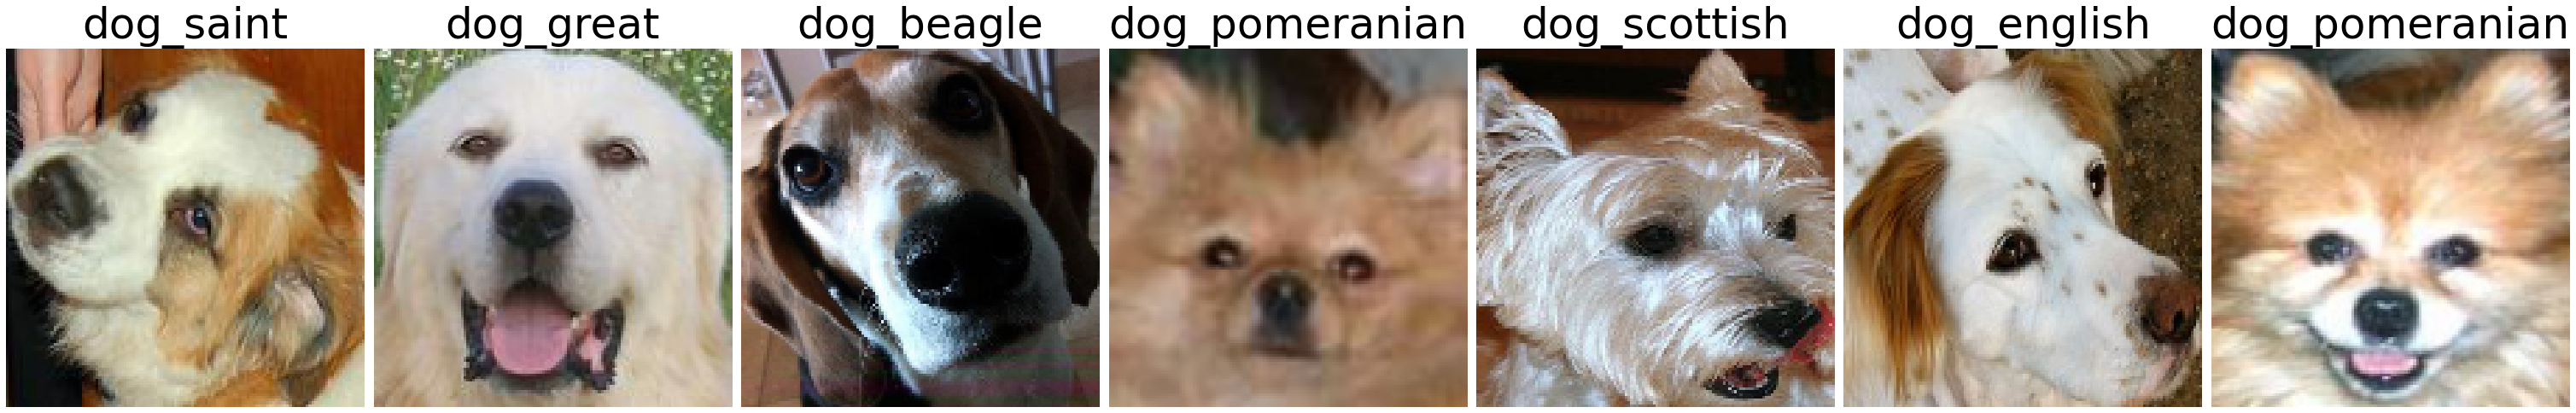

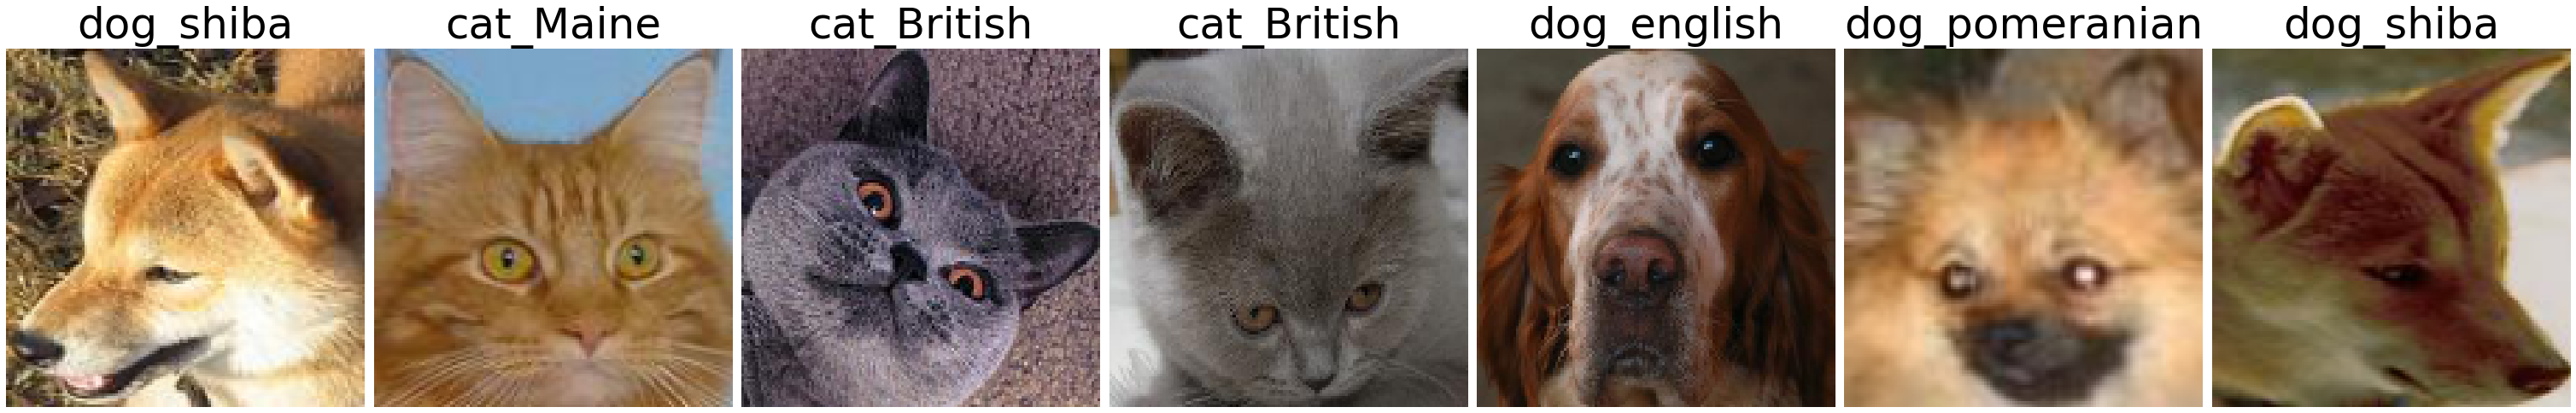

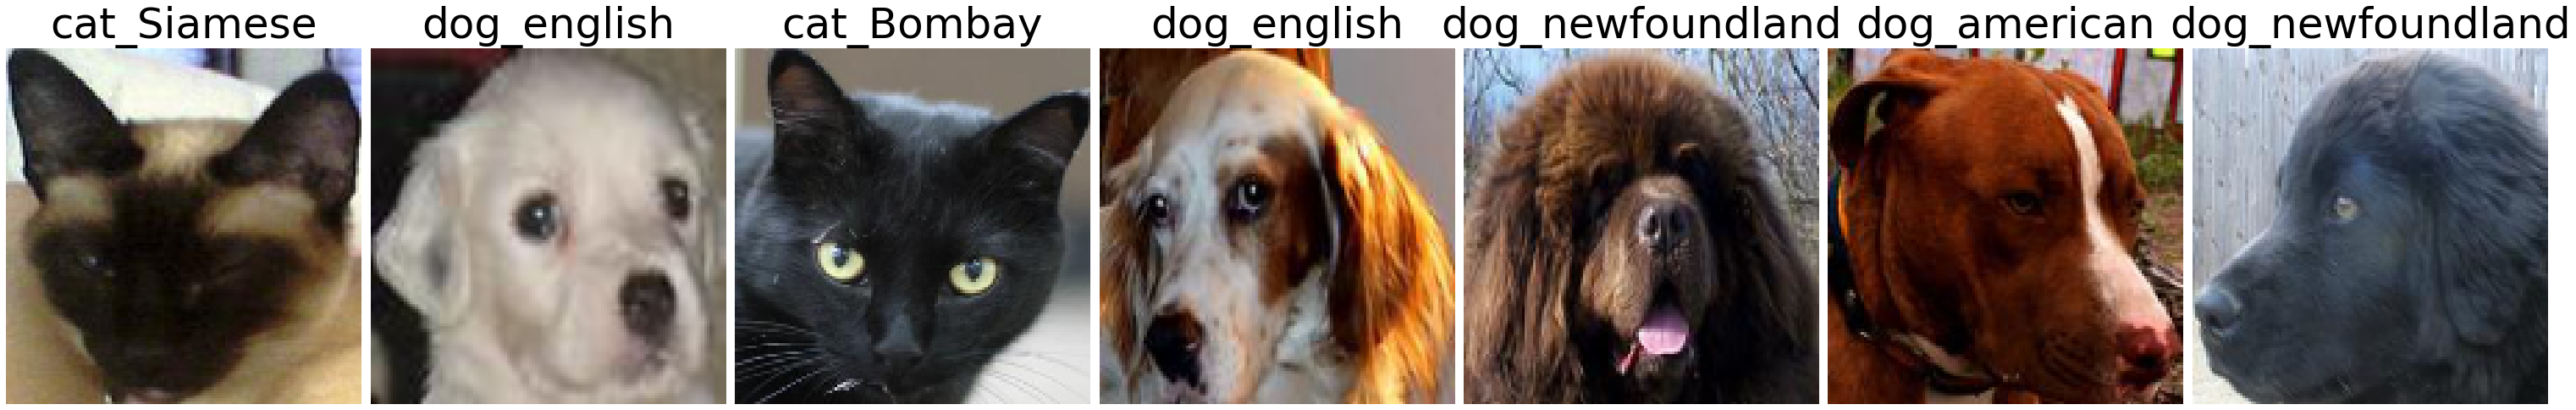

In [5]:
for _,(i,l) in zip(range(3),train):
    display_images(i[:7]/255.,titles=[train.class_names[x] for x in l[:7]],fontsize=50)

You also need to make sure that all input data is normalized between 0 and 1. In some cases (if you have used `ToTensor` transform in PyTorch), this is already the case, while in others you need to do it manually.

In [6]:
train = train.map(lambda i,c : (i/255.0,c))
test = test.map(lambda i,c : (i/255.0,c))

## Define a neural network

For image classification, you should probably define a convolutional neural network with several layers. What to keep an eye for:
* Keep in mind the pyramid architecture, i.e. number of filters should increase as you go deeper
* Do not forget activation functions between layers (ReLU) and Max Pooling
* Final classifier can be with or without hidden layers, but the number of output neurons should be equal to number of classes.

An important thing is to get the activation function on the last layer + loss function right:
* In Tensorflow, you can use `softmax` as the activation, and `sparse_categorical_crossentropy` as loss. The difference between sparse categorical cross-entropy and non-sparse one is that the former expects output as the number of class, and not as one-hot vector.
* In PyTorch, ...

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(image_size,image_size,3)),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes,activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'],optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0

## Train the Neural Network

Now we are ready to train the neural network. During training, please collect accuracy on train and test data on each epoch, and then plot the accuracy to see if there is overfitting.

In [10]:
hist = model.fit(train,validation_data=test,epochs=10)

Epoch 1/10
81/81 [==============================] - 13s 148ms/step - loss: 3.3487 - acc: 0.0934 - val_loss: 2.6186 - val_acc: 0.2664
Epoch 2/10
81/81 [==============================] - 12s 140ms/step - loss: 2.1678 - acc: 0.4064 - val_loss: 1.9984 - val_acc: 0.4315
Epoch 3/10
81/81 [==============================] - 12s 143ms/step - loss: 1.4410 - acc: 0.5980 - val_loss: 1.8549 - val_acc: 0.4782
Epoch 4/10
81/81 [==============================] - 12s 143ms/step - loss: 0.9871 - acc: 0.7262 - val_loss: 2.1570 - val_acc: 0.4907
Epoch 5/10
81/81 [==============================] - 12s 143ms/step - loss: 0.5715 - acc: 0.8387 - val_loss: 2.1907 - val_acc: 0.5187
Epoch 6/10
81/81 [==============================] - 12s 150ms/step - loss: 0.3192 - acc: 0.9031 - val_loss: 2.4858 - val_acc: 0.5016
Epoch 7/10
81/81 [==============================] - 12s 143ms/step - loss: 0.1328 - acc: 0.9676 - val_loss: 2.7907 - val_acc: 0.5031
Epoch 8/10
81/81 [==============================] - 12s 145ms/step - 

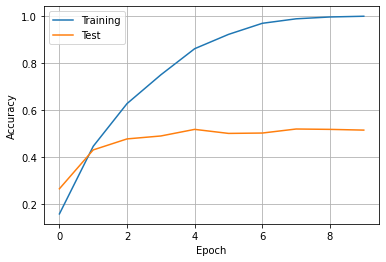

In [17]:
plt.plot(hist.history['acc'],label='Training')
plt.plot(hist.history['val_acc'],label='Test')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

What can you say about overfitting? What can be done to improve the accuracy of the model

## Optional: Calculate Top3 Accuracy

In this exercise, we were dealing with classification with quite high number of classes (35), so our result - around 50% validation accuracy - is pretty good. Standard ImageNet dataset has even more - 1000 classes.

In such cases it is difficult to ensure that model **always** correctly predicts the class. There are cases when two breeds are very similar to each other, and the model returns very similar probablities (eg., 0.45 and 0.43). If we measure standard accuracy, it will be considered a wrong case, even though the model did very small mistake. This, we often measure another metric - an accuracy within top 3 most probable predictions of the model.

We consider the case accurate if target label is contained within top 3 model predictions. 

To compute top-3 accuracy on the test dataset, you need to manually go over the dataset, apply the neural network to get the prediction, and then do the calculations. Some hints:

* In Tensorflow, use `tf.nn.in_top_k` function to see if the `predictions` (output of the model) are in top-k (pass `k=3` as parameter), with respect to `targets`. This function returns a tensor of boolean values, which can be converted to `int` using `tf.cast`, and then accumulated using `tf.reduce_sum`.
* In PyTorch, you can use `torch.topk` function to get indices of classes with highers probabilities, and then see if the correct class belongs to them. See [this](https://gist.github.com/weiaicunzai/2a5ae6eac6712c70bde0630f3e76b77b) for more hints.


In [18]:
correct = 0
total = 0
for t,l in test:
    r = model(t)
    res = tf.nn.in_top_k(predictions=r,targets=l,k=3)
    correct += tf.reduce_sum(tf.cast(res,tf.int32))
    total += len(l)
print(correct/total)

tf.Tensor(0.7663551401869159, shape=(), dtype=float64)


## Optional: Build Cats vs. Dogs classification

We also want to see how accurate our binary cats vs. dogs classification would be on the same dateset. To do it, we need to adjust labels:

In [46]:
classmap = tf.constant([1 if n.startswith('cat_') else 0 for n in class_names])

def mapclass(x,y):
    return x,tf.map_fn(lambda t: classmap[t],y)
    
train_bin = train.map(mapclass)
test_bin = test.map(mapclass)

In [47]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(image_size,image_size,3)),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.compile(loss='binary_crossentropy',metrics=['acc'],optimizer='adam')
hist = model.fit(train_bin,validation_data=test_bin,epochs=10)

Epoch 1/10
81/81 [==============================] - 11s 123ms/step - loss: 8.9018 - acc: 0.6244 - val_loss: 0.3830 - val_acc: 0.8396
Epoch 2/10
81/81 [==============================] - 10s 123ms/step - loss: 0.3071 - acc: 0.8758 - val_loss: 0.3252 - val_acc: 0.8614
Epoch 3/10
81/81 [==============================] - 11s 129ms/step - loss: 0.2417 - acc: 0.8987 - val_loss: 0.3497 - val_acc: 0.8785
Epoch 4/10
81/81 [==============================] - 10s 127ms/step - loss: 0.1812 - acc: 0.9339 - val_loss: 0.4023 - val_acc: 0.8707
Epoch 5/10
81/81 [==============================] - 11s 132ms/step - loss: 0.1257 - acc: 0.9461 - val_loss: 0.3090 - val_acc: 0.8988
Epoch 6/10
81/81 [==============================] - 10s 125ms/step - loss: 0.0945 - acc: 0.9574 - val_loss: 0.3234 - val_acc: 0.9097
Epoch 7/10
81/81 [==============================] - 10s 124ms/step - loss: 0.0519 - acc: 0.9794 - val_loss: 0.3106 - val_acc: 0.9097
Epoch 8/10
81/81 [==============================] - 10s 126ms/step - 